# Nonlinear decomposition based on the Correntropy Function

Correntropy is a generalized correlation function. In this demo data points from two Gaussian distributions is generated. Using conventional Principal Component Analysis (PCA), the eigenvectors of the covariance matrix of the data give an orthogonal set of axes in which data can be projected. These axes correspond to the directions in which the data (in input space) varies the most.

This procedure can be generalized using correntropy. The eigenvectors of the correntropy matrix of the feature vectors yields a projection of maximum variance in the RKHS defined by correntropy. 

The advantage of over kernel-pca  is that the correntropy matrix has the same dimension as the covariance matrix, hence it is more interpretable and more efficient to compute (the Gram matrix in KPCA grows with the number of samples). 

RKHS: Reproducing Kernel Hilbert Space of functions

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import roc_curve

In [2]:
# Generate Data
N = 100
mu1 = [-1.0, 0.0]
mu2 = [0.0, 1.0]
S1 = [[1.0, -0.5],[0.0, 0.1]]
S2 = [[0.1, 0.0],[-0.5, 1.0]]
data = np.concatenate((np.random.multivariate_normal(mu1, S1, N),
                       np.random.multivariate_normal(mu2, S2, N)))

Eigenvalues:
[ 1.19669696  0.78668677]


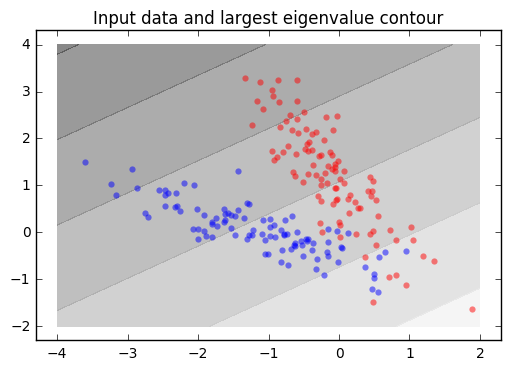

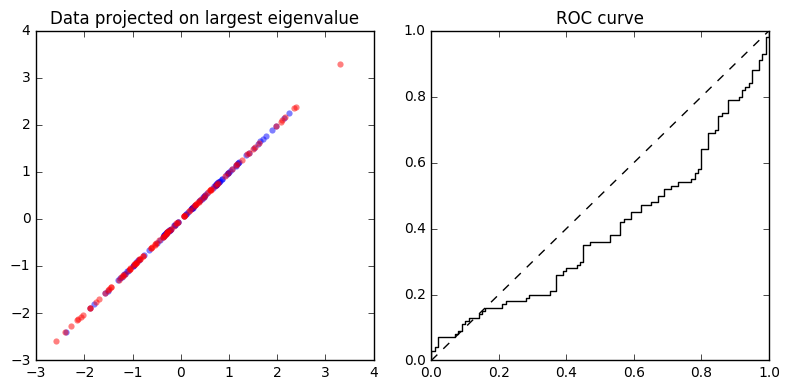

In [4]:
# PCA fit 
pca = PCA(n_components=2)
pca.fit(data)
print("Eigenvalues:")
print(pca.explained_variance_)
I = np.argmax(pca.explained_variance_)

# Pca projetion
x_range = np.linspace(-4.0, 2.0, num=100)
y_range = np.linspace(-2.0, 4.0, num=100)
X, Y = np.meshgrid(x_range, y_range)
V_projected = np.zeros(shape=(X.shape[0], X.shape[1], 2))
for i in range(X.shape[0]):
    V_projected[i, :, :] = pca.transform(np.stack([X[i,:],Y[i,:]]).T)
plt.figure()
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
plt.title('Input data and largest eigenvalue contour')
plt.contourf(X, Y, V_projected[:, :, I], alpha=0.5, cmap=plt.cm.gray)

plt.scatter(data[:N, 0], data[:N,1], linewidths=0, alpha=0.5, c='b')
plt.scatter(data[N:, 0], data[N:,1], linewidths=0, alpha=0.5, c='r')

data_proj = pca.transform(data)
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,2,1)
plt.title('Data projected on largest eigenvalue')
ax.scatter(data_proj[:N, I], data_proj[:N, I], linewidths=0, alpha=0.5, c='b')
ax.scatter(data_proj[N:, I], data_proj[N:, I], linewidths=0, alpha=0.5, c='r')
ax = fig.add_subplot(1,2,2)
plt.title('ROC curve')
labels = np.zeros(shape=(2*N,))
labels[N:] = 1.0
fpr, tpr, th = roc_curve(labels, data_proj[:, I])
ax.plot(fpr, tpr, 'k-')
ax.plot([0.0, 1.0], [0.0, 1.0], 'k--')
plt.tight_layout()

When projecting the data onto the largest eigenvector it is very hard the separate the data coming from the different distributions. We will see that this is not the case when Correntropy is used instead of Covariance.

In [6]:
def correntropy(x, y):
    N = len(x)
    V =  np.average(np.exp(-0.5*(x - y)**2/s**2))
    CIP = 0.0 # mean in feature space should be subtracted!!
    for i in range(0, N):
        CIP += np.average(np.exp(-0.5*(x- y[i])**2/s**2))/N
    return V - CIP

# Compute correntropy matrix and get eigenvalues
s = 0.4
V = pairwise_distances(data.T, metric=correntropy, n_jobs=4)
eigval, eigvec = np.linalg.eigh(V)
I = np.argmax(eigval)
print("Eigenvalues:")
print(eigval)

X, Y = np.meshgrid(x_range, y_range)
V_projected = np.zeros(shape=(X.shape[0], X.shape[1], 2))
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        V_projected[i, j, :] = np.sum(eigvec*np.average(np.exp(-0.5*(data - [X[i,j], Y[i,j]])**2/s**2), axis=0), axis=1)

Eigenvalues:
[ 0.67402998  0.74793949]


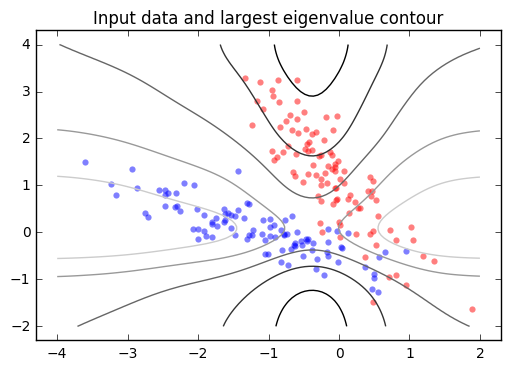

In [7]:
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
plt.title('Input data and largest eigenvalue contour')
plt.contour(X, Y, V_projected[:, :, I],  cmap=plt.cm.gray)
plt.scatter(data[:N, 0], data[:N, 1], linewidths=0, alpha=0.5, c='b')
plt.scatter(data[N:, 0], data[N:, 1], linewidths=0, alpha=0.5, c='r')

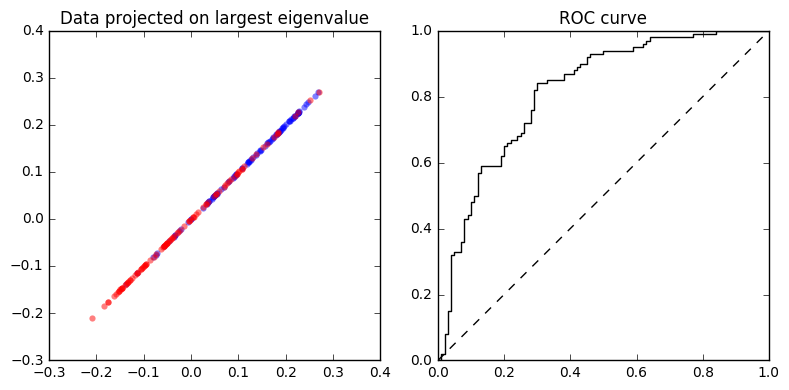

In [8]:
data_proj = np.zeros(shape=(N*2, 2))
for i in range(2*N):
    data_proj[i, :] = np.dot(eigvec, np.average(np.exp(-0.5*(data - data[i,:])**2/s**2), axis=0))
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,2,1)
plt.title('Data projected on largest eigenvalue')
ax.scatter(data_proj[:N, I], data_proj[:N, I], linewidths=0, alpha=0.5, c='b')
ax.scatter(data_proj[N:, I], data_proj[N:, I], linewidths=0, alpha=0.5, c='r')
ax = fig.add_subplot(1,2,2)
plt.title('ROC curve')
labels = np.zeros(shape=(2*N,))
labels[:N] = 1.0
fpr, tpr, th = roc_curve(labels, data_proj[:, I])
ax.plot(fpr, tpr, 'k-')
ax.plot([0.0, 1.0], [0.0, 1.0], 'k--')
plt.tight_layout()